In [210]:
import os 
import pickle
import glob
import re
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [202]:
import hashlib
hasher = hashlib.sha256

In [4]:
data_path = 'data' 
actor_files = sorted(glob.glob(data_path + '/actor*.pkl'))

In [254]:
with open(actor_files[2], 'rb') as f: 
    actor_data = pickle.load(f)

In [93]:
unit_conversion = dict(
    cm_per_ft = 30.48,
    cm_per_in = 2.54,
    kg_per_lb = 0.45359237
)

def _process_data_unit(s, unit):
    s = re.findall('\d*\s*' + unit, s)
    if len(s) == 0:
        return 0
    elif len(s) == 1:
        return float(s[0].replace(unit, '').strip())
    else:
        raise ValueError('Cannot process "%s" with unit="%s"' %(s, unit))
        
def process_height_cm(s):
    if 'cm' in s:
        h_cm = _process_data_unit(s, 'cm')
    elif 'feet' in s or 'ft' in s: 
        h_ft = _process_data_unit(s, 'feet')
        h_in = _process_data_unit(s, 'inches')
        h_cm = h_ft * unit_conversion['cm_per_ft'] + h_in * unit_conversion['cm_per_in']
    else:
        return 0
    return h_cm 

def process_weight_kg(s):
    if 'kg' in s: 
        w_kg = _process_data_unit(s, 'kg')
    elif 'lbs' in s: 
        w_lbs = _process_data_unit(s, 'lbs')
        w_kg = w_lbs * unit_conversion['kg_per_lb']
    else:
        return 0 
    return w_kg 


In [277]:
def _is_award_data(k,v):
    award_possibles = ['award', 'nominee', 'nominate', 'winner'] 
    s = ';'.join([k] + v).lower()
    return any([x in s for x in award_possibles])

def hash_actor_id(actor):
    source = actor['SOURCE'].replace('https://www.iafd.com', '')
    return hasher(source.encode()).hexdigest()
    
def process_actor_awards(actor_info):
    num_awards = [len(v) for k, v in actor_info.items() 
                  if _is_award_data(k, v)]
    if len(num_awards) == 0:
        return 0
    return sum(num_awards)

def process_actor_info(actor):
    selected_keys = ['Astrology', 'Ethnicity', 'Nationality', 
                     'Hair Color', 'Height', 'Weight', 
                     'Tattoos', 'Piercings']   
    actor_info = actor['INFO']
    
    # ID from source
    info = dict(ID = hash_actor_id(actor))
    
    # get specific keys
    info.update({k.lower().replace(' ', '_'): ','.join(actor_info.get(k, ['None']))
                 for k in selected_keys})    
    
    # turn these into boolean
    info['has_tattoos'] = info['tattoos'].lower() != 'None' 
    info['has_piercings'] = info['piercings'].lower() != 'None' 
    del info['tattoos'], info['piercings']
    
    # appearance to floats
    info['height_cm'] = process_height_cm(info['height'])
    info['weight_kg'] = process_weight_kg(info['weight'])
    del info['height'], info['weight']
    
    # number of awards
    info['num_awards'] = process_actor_awards(actor_info)
    
    return info
    

def process_actor_years(actor):
    actor_id = hash_actor_id(actor)
    actor_years = actor['MOVIES'].Year
    actor_years = actor_years[actor_years != '']
    actor_years = actor_years.astype('float')
    
    actor_years, year_counts = np.unique(actor_years, return_counts=True)
    return pd.DataFrame({'ID': actor_id, 'year': actor_years, 'count': year_counts})


In [ ]:
actor_results = dict(info = [], years = [])

for file in tqdm(actor_files):
    with open(file, 'rb') as f: 
        actor_data = pickle.load(f)
    actor_results['info'].append(pd.DataFrame(map(process_actor_info, actor_data)))
    actor_results['years'].append(pd.concat(map(process_actor_years, actor_data)))

actor_results = {k: pd.concat(v) for k, v in actor_results.items()}


In [358]:
df = actor_results['years'].sort_values(by='year')
grouper = df.groupby('ID')
min_years = grouper['year'].transform('min')
sum_counts = grouper['count'].transform('sum')
df_norm = df.assign(
    year = df['year'] - min_years,
    count = df['count'] / sum_counts
)

num_actors = grouper.ngroups

<AxesSubplot:xlabel='year'>

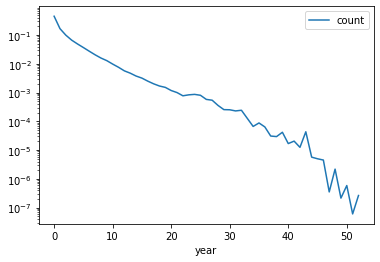

In [363]:
df_plt = df_norm.groupby('year').sum() / num_actors
df_plt.plot(logy=True)